In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import pymc as pm

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "martinellis/nhl-game-data",
  "game_teams_stats.csv",
)

df.head()

<ipython-input-21-f0658c1e529f>:12: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide
0,2016020045,4,away,False,REG,Dave Hakstol,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,11.0,left
1,2016020045,16,home,True,REG,Joel Quenneville,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,9.0,left
2,2017020812,24,away,True,OT,Randy Carlyle,4.0,34.0,16.0,6.0,3.0,1.0,43.8,7.0,4.0,14.0,right
3,2017020812,7,home,False,OT,Phil Housley,3.0,33.0,17.0,8.0,2.0,1.0,56.2,5.0,6.0,14.0,right
4,2015020314,21,away,True,REG,Patrick Roy,4.0,29.0,17.0,9.0,3.0,1.0,45.7,13.0,5.0,20.0,left


### 1.

Perform Bayesian Logistic Regression on a binary outcome data of your choosing, then provide inference with Bayesian posterior analysis and report MCMC diagnostics.

Output()

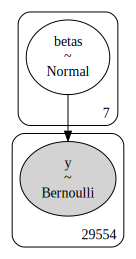

In [ ]:
cols = ["won", "goals", "shots", "hits", "pim", "powerPlayOpportunities", "giveaways", "faceOffWinPercentage"]
df1 = df.dropna()[cols]

y = df1["won"].values
# Standardizing values to reduce extreme curvature
scaler = StandardScaler()
X = scaler.fit_transform(df1.drop(columns=["won"]).values)
n, p = X.shape

with pm.Model() as win:
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    y_obs = pm.Bernoulli('y', p=pm.math.sigmoid(X@betas), observed=y)

    idata = pm.sample()

pm.model_to_graphviz(win)

In [ ]:
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],1.947,0.023,1.904,1.992,0.0,0.0,2439.0,1674.0,1.0
betas[1],-0.252,0.015,-0.285,-0.224,0.0,0.0,2423.0,1583.0,1.0
betas[2],-0.022,0.015,-0.051,0.005,0.0,0.0,2631.0,1698.0,1.0
betas[3],-0.206,0.018,-0.239,-0.168,0.0,0.0,2227.0,1601.0,1.0
betas[4],-0.045,0.015,-0.076,-0.017,0.0,0.0,2159.0,1576.0,1.0
betas[5],-0.065,0.015,-0.095,-0.038,0.0,0.0,2567.0,1572.0,1.0
betas[6],0.065,0.015,0.033,0.093,0.0,0.0,2555.0,1623.0,1.0


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

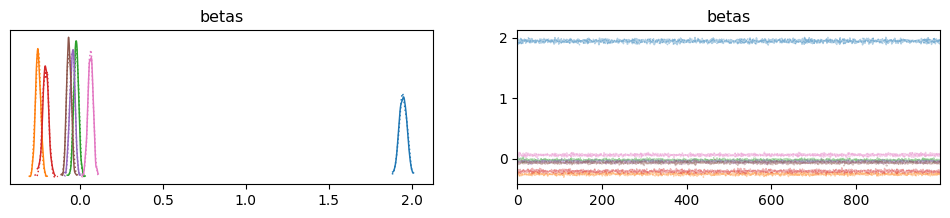

In [ ]:
az.plot_trace(idata, var_names=["betas"])

<Axes: >

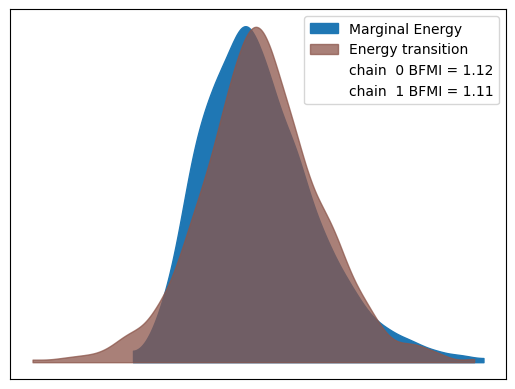

In [ ]:
az.plot_energy(idata)

### 2.

Perform Bayesian Multivariate Regression on a multiple continuous outcomes data of your choosing, downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p`, choose a "reasonably small" sized data set to perform an actual analysis, then provide inference with Bayesian posterior analysis and report MCMC diagnostics.

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

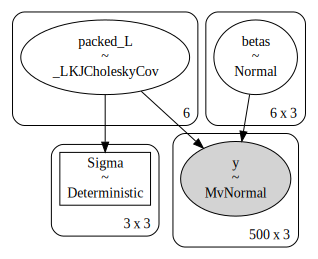

In [ ]:
cols = ["won", "goals", "shots", "hits", "pim", "powerPlayOpportunities", "giveaways", "takeaways", "faceOffWinPercentage"]
df2 = df.dropna()[cols]

n = [100, 500, 1000, 10000, df2.shape[0]]
m = [["goals", "shots"], ["goals", "shots", "hits"], ["goals", "shots", "hits", "pim"]]
sample = df2.sample(n=n[1])
y = sample[m[1]].values

# Standardizing values to reduce extreme curvature
scaler = StandardScaler()
y = scaler.fit_transform(sample[m[1]].values)
X = scaler.fit_transform(sample.drop(columns=m[1]).values)
n, p = X.shape
m = y.shape[1]

with pm.Model() as goal_shot_hit:
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False
    )
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y_obs = pm.MvNormal('y', mu=X@betas, chol=L, observed=y)

    idata2 = pm.sample()

pm.model_to_graphviz(goal_shot_hit)

In [ ]:
e_b_m = az.summary(idata2)["ess_bulk"].mean()
e_b_v = az.summary(idata2)["ess_bulk"].var()
e_t_m = az.summary(idata2)["ess_tail"].mean()
e_t_v = az.summary(idata2)["ess_tail"].var()
r = az.summary(idata2)["r_hat"].mean()
hdi = az.hdi(idata2, hdi_prob=0.95)
print("ESS bulk mean: ", e_b_m)
print("ESS bulk variance: ", e_b_v)
print("ESS tail mean: ", e_t_m)
print("ESS tail variance: ", e_t_v)
print("R-hat: ", r)
print("HDI: ", hdi)

ESS bulk mean:  4532.787878787879
ESS bulk variance:  376085.7348484848
ESS tail mean:  1481.5757575757575
ESS tail variance:  14983.939393939394
R-hat:  1.0003030303030302
HDI:  <xarray.Dataset> Size: 744B
Dimensions:         (Sigma_dim_0: 3, Sigma_dim_1: 3, hdi: 2, betas_dim_0: 6,
                     betas_dim_1: 3, packed_L_dim_0: 6)
Coordinates:
  * Sigma_dim_0     (Sigma_dim_0) int64 24B 0 1 2
  * Sigma_dim_1     (Sigma_dim_1) int64 24B 0 1 2
  * betas_dim_0     (betas_dim_0) int64 48B 0 1 2 3 4 5
  * betas_dim_1     (betas_dim_1) int64 24B 0 1 2
  * packed_L_dim_0  (packed_L_dim_0) int64 48B 0 1 2 3 4 5
  * hdi             (hdi) <U6 48B 'lower' 'higher'
Data variables:
    Sigma           (Sigma_dim_0, Sigma_dim_1, hdi) float64 144B 0.6119 ... 1...
    betas           (betas_dim_0, betas_dim_1, hdi) float64 288B 0.4806 ... 0...
    packed_L        (packed_L_dim_0, hdi) float64 96B 0.7822 0.884 ... 1.046


**Analysis of the effects of different `n`,`m`,`p` values after brute force testing:**

|n (# of samples) | m (# of predictor vars) | p (# of outcome vars) | Convergence | Computation Time | Posterior Quality (PPC, ESS, R-hat, HDI, etc.) |
| --- | --- | --- | --- | --- | --- |
| 100 | 2 | 7 | Converged | 00:45 | Medium underfitting, Medium uncertainty |
| 100 | 3 | 6 | Converged | 00:50 | High underfitting, High uncertainty |
| 100 | 4 | 5 | Converged | 00:48 | Medium underfitting, High uncertainty |
| 500 | 2 | 7 | Converged | 00:54 | Very high underfitting, Very low uncertainty |
| 500 | 3 | 6 | Converged | 00:51 | Medium underfitting, Low uncertainty |
| 1000 | 2 | 7 | Converged | 00:54 | High underfitting, Low uncertainty |
| 1000 | 3 | 6 | Converged | 00:59 | High underfitting, Medium uncertainty |
| 10000 | 2 | 7 | Diverged | 02:13 | N/A |
| 10000 | 3 | 6 | Converged | 01:34 | Very high underfitting, Low uncertainty  |
| `df.shape[0]` | 3 | 6 |  Diverged | 06:11 | N/A |

Conclusion: Based on results, `n=500`, `p=3`, `m=5` strikes a good balance between computational efficiency and stable inference. Larger datasets (n=10000+) showed increased divergences likely due to high-dimensional covariance estimation and the too-curvy surface.

In [ ]:
az.summary(idata2, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",0.694,0.045,0.612,0.781,0.001,0.001,4151.0,1620.0,1.00
"Sigma[0, 1]",0.159,0.038,0.088,0.235,0.001,0.000,5150.0,1380.0,1.00
"Sigma[0, 2]",-0.053,0.037,-0.124,0.016,0.001,0.000,5312.0,1396.0,1.00
"Sigma[1, 0]",0.159,0.038,0.088,0.235,0.001,0.000,5150.0,1380.0,1.00
"Sigma[1, 1]",0.945,0.062,0.826,1.060,0.001,0.001,4348.0,1350.0,1.00
"Sigma[1, 2]",0.072,0.044,-0.017,0.160,0.001,0.001,4168.0,1390.0,1.00
"Sigma[2, 0]",-0.053,0.037,-0.124,0.016,0.001,0.000,5312.0,1396.0,1.00
"Sigma[2, 1]",0.072,0.044,-0.017,0.160,0.001,0.001,4168.0,1390.0,1.00
"Sigma[2, 2]",0.994,0.060,0.881,1.117,0.001,0.001,5139.0,1556.0,1.00
"betas[0, 0]",0.553,0.038,0.481,0.627,0.001,0.000,5405.0,1380.0,1.00


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

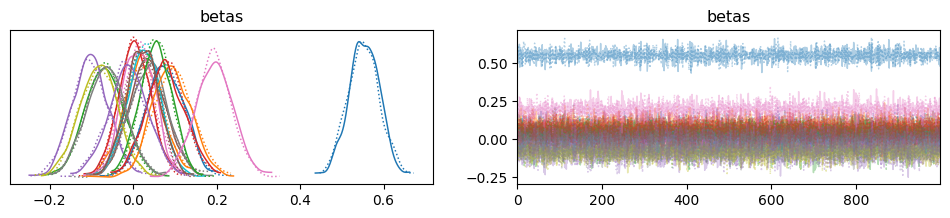

In [ ]:
az.plot_trace(idata2, var_names=["betas"])

<Axes: >

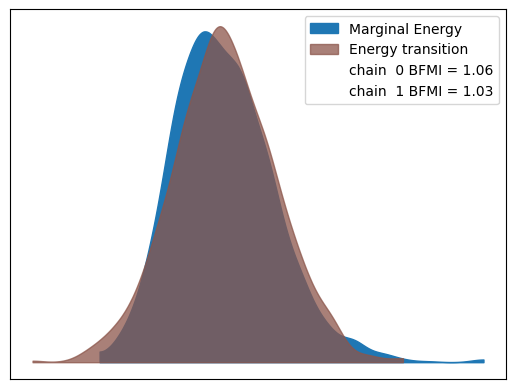

In [ ]:
az.plot_energy(idata2)

[[ 0.69435743  0.15852689 -0.05344513]
 [ 0.15852689  0.94519351  0.07153314]
 [-0.05344513  0.07153314  0.99449725]]


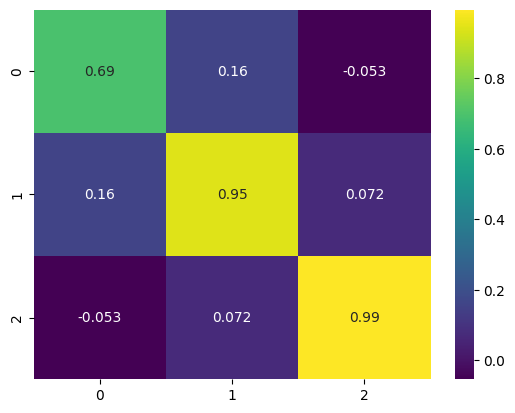

In [ ]:
Sigma_samples = idata2.posterior["Sigma"].values
mean_Sigma = np.mean(Sigma_samples, axis=(0, 1))
sns.heatmap(mean_Sigma, annot=True, cmap="viridis")
plt.show()

### 3.

Perform Bayesian Multivariate Classifcation on a multiple binary outcomes data of your choosing, downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p`, choose a "reasonably small" sized data set to perform an actual analysis, then provide inference with Bayesian posterior analysis and report MCMC diagnostics.

In [ ]:
cols = ["game_id", "HoA", "won", "settled_in", "goals", "shots", "hits", "pim", "powerPlayOpportunities", "powerPlayGoals", "giveaways", "takeaways", "faceOffWinPercentage", "startRinkSide"]
df3 = df.dropna()[cols]

# Changing original data to make a binary outcomes dataset
df3 = df3.assign(
    at_home = lambda df_: df_['HoA'].map(lambda HoA: True if HoA == 'home' else False),
    went_to_OT = lambda df_: df_['settled_in'].map(lambda settled_in: True if settled_in == 'OT' else False),
    shutout = lambda df_: df_['goals'].map(lambda goals: True if goals > 0 else False),
    more_penalties_than_opponent = lambda df_: df_.sort_values(
        by=["game_id", "pim"], ascending=[True, False]
    ).groupby("game_id")["pim"].transform(lambda pim: pim == pim.max()),
    more_gives_than_takes = lambda df_: df_['giveaways'] > df_['takeaways'],
    more_faceoffs_won_than_lost = lambda df_: df_['faceOffWinPercentage'] > 50,
)
newcols = ["at_home", "won", "went_to_OT", "shutout", "shots", "hits", "powerPlayGoals", "more_penalties_than_opponent", "more_gives_than_takes", "more_faceoffs_won_than_lost"]
df3 = df3[newcols]

n = [100, 500, 1000, 10000, df3.shape[0]]
m = [["won", "shutout"], ["won", "went_to_OT" ,"shutout"], ["won", "went_to_OT" ,"shutout", "more_gives_than_takes",]]
sample = df3.sample(n=n[2])

y = sample[m[1]].values
# Standardizing values to reduce extreme curvature
scaler = StandardScaler()
X = scaler.fit_transform(sample.drop(columns=m[1]).values)

n, p = X.shape
m = y.shape[1]

Output()

/usr/local/lib/python3.11/dist-packages/pymc/step_methods/metropolis.py:320: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


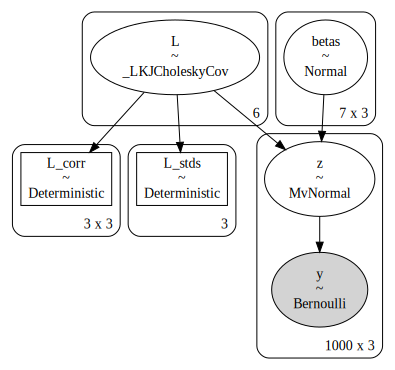

In [ ]:
with pm.Model() as won_OT_shutout:
    L,R,std = pm.LKJCholeskyCov("L", n=m, eta=2.0,
                                sd_dist=pm.Exponential.dist(1.0, shape=m),
                                compute_corr=True)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    z = pm.MvNormal('z', mu=X@betas, chol=L)
    y_obs = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y)

    idata3 = pm.sample(1000, tune=500, step=pm.Metropolis(), cores=2)

pm.model_to_graphviz(won_OT_shutout)

In [ ]:
e_b_m = az.summary(idata3)["ess_bulk"].mean()
e_t_m = az.summary(idata3)["ess_tail"].mean()
r = az.summary(idata3)["r_hat"].mean()
hdi = az.hdi(idata3, hdi_prob=0.95)
print("ESS bulk mean: ", e_b_m)
print("ESS tail mean: ", e_t_m)
print("R-hat: ", r)
print("HDI: ", hdi)

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


ESS bulk mean:  59.30602171767028
ESS tail mean:  150.6604146100691
R-hat:  1.0915339038841343
HDI:  <xarray.Dataset> Size: 57kB
Dimensions:       (L_dim_0: 6, hdi: 2, L_corr_dim_0: 3, L_corr_dim_1: 3,
                   L_stds_dim_0: 3, betas_dim_0: 7, betas_dim_1: 3,
                   z_dim_0: 1000, z_dim_1: 3)
Coordinates:
  * L_dim_0       (L_dim_0) int64 48B 0 1 2 3 4 5
  * L_corr_dim_0  (L_corr_dim_0) int64 24B 0 1 2
  * L_corr_dim_1  (L_corr_dim_1) int64 24B 0 1 2
  * L_stds_dim_0  (L_stds_dim_0) int64 24B 0 1 2
  * betas_dim_0   (betas_dim_0) int64 56B 0 1 2 3 4 5 6
  * betas_dim_1   (betas_dim_1) int64 24B 0 1 2
  * z_dim_0       (z_dim_0) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * z_dim_1       (z_dim_1) int64 24B 0 1 2
  * hdi           (hdi) <U6 48B 'lower' 'higher'
Data variables:
    L             (L_dim_0, hdi) float64 96B 0.2641 0.3383 ... 0.2515 0.8065
    L_corr        (L_corr_dim_0, L_corr_dim_1, hdi) float64 144B 1.0 1.0 ... 1.0
    L_stds        (L_st

**Analysis of the effects of different `n`,`m`,`p` values after brute force testing:**

|n (# of samples) | m (# of predictor vars) | p (# of outcome vars) | Convergence | Computation Time | Posterior Quality (ESS, R-hat, HDI) |
| --- | --- | --- | --- | --- | --- |
| 100 | 2 | 8 | Diverged | 02:25 | Very bad ESS, Very bad R-hat, High uncertainty |
| 100 | 3 | 7 | Diverged | 03:56 | Bad ESS, Bad R-hat, High uncertainty |
| 100 | 4 | 6 | Diverged | 06:59 | Medium ESS, Very bad R-hat, Very High uncertainty |
| 500 | 3 | 7 | Diverged | 21:13 | Medium ESS, Very bad R-hat, High uncertainty |
| 500 | 4 | 6 | Diverged | 22:01 | Bad ESS, Medium R-hat, Very high uncertainty |
| 1000 | 3 | 7 | Diverged | 49:57 | Decent ESS, Medium R-hat, Medium uncertainty |
| 1000 | 4 | 6 | Diverged | 1:50:33 | Medium ESS, Bad R-hat, Medium uncertainty |
| 10000 | 3 | 7 | N/A | N/A | N/A |
| 10000 | 4 | 6 | N/A | N/A | N/A  |
| `df.shape[0]` | 2 | 6 |  N/A | ETA: 11:47:26 | N/A |

Conclusion: Based on results, `n=1000`, `p=3`, `m=7` strikes a good balance between computational efficiency and stable inference. Every single model, without exception and no matter how much I tuned and changed (i.e. `n`, `m`, `p`, target_accept, beta prior, etc.), would produce divergences without fail. This means that our parameterization of the model as laid out in the instructions is erroneous which is causing this phenomenon of frequent divergences in our model. In the end, I decided to change our sampler to a MH as it did not diverge (albeit took 2 hours almost to sample just 1500).

In [ ]:
az.summary(idata3, hdi_prob=0.95)

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[0],0.303,0.020,0.264,0.338,0.005,0.004,18.0,36.0,1.09
L[1],-0.275,0.217,-0.593,-0.030,0.148,0.123,3.0,12.0,2.24
L[2],0.674,0.077,0.545,0.816,0.050,0.041,2.0,8.0,2.55
L[3],0.583,0.457,-0.001,1.271,0.319,0.269,2.0,11.0,3.06
L[4],-0.970,0.263,-1.496,-0.548,0.171,0.143,2.0,11.0,2.38
...,...,...,...,...,...,...,...,...,...
"z[998, 1]",-0.383,0.464,-1.400,0.409,0.060,0.043,61.0,192.0,1.06
"z[998, 2]",0.680,0.751,-0.639,2.328,0.127,0.120,36.0,280.0,1.06
"z[999, 0]",-0.274,0.288,-0.845,0.298,0.060,0.043,23.0,132.0,1.09
"z[999, 1]",-0.257,0.564,-1.371,0.796,0.075,0.053,61.0,134.0,1.03


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

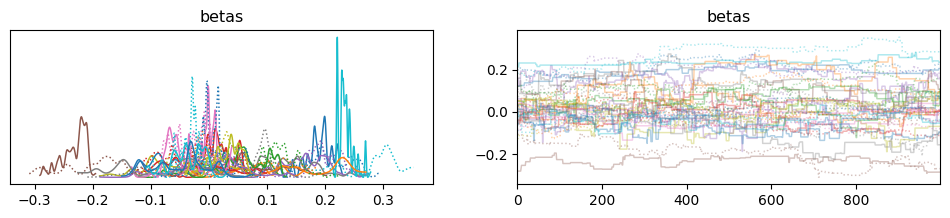

In [ ]:
az.plot_trace(idata3, var_names=["betas"])

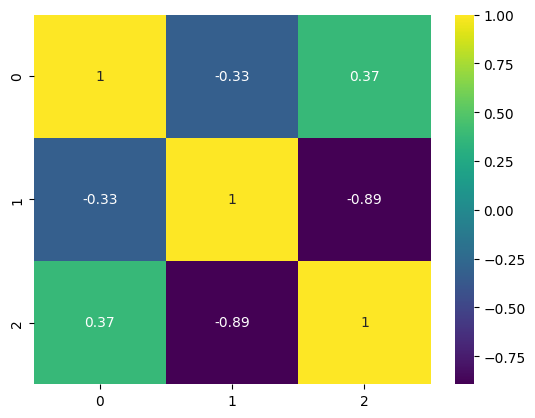

In [ ]:
L_samples = idata3.posterior["L_corr"].values
mean_L = np.mean(L_samples, axis=(0, 1))
sns.heatmap(mean_L, annot=True, cmap="viridis")
plt.show()